# 一个隐含层的简单神经网络

本例给出能把二维输入向量映射到二元输出值得简单神经网络架构。

有两个神经元的输入层，一个带六个隐含神经元的隐含层，一个神经元的输出层。

通过各层之间权重矩阵的方式来表达该架构。

- $W_h$ ：输入层和隐含层之间的权重矩阵
- $W_o$ : 隐含层和输出层之间的权重矩阵

此外，连接神经元的权重，每个隐含层和输出层的神经元有个常数 $1$ 的偏置。

训练集合由 $m=750$ 个样本组成。这样，就有下述矩阵形状：

- $X=(750, 2)$ ：训练集合形状
- $Y=(750, 1)$ ：目标形状
- $(m, n_{hidden})=(2, 6)$ ： $W_h$ 形状
- $(1, n_{hidden})=(1, 6)$ ： $b_h$ （偏置）形状
- $(n_{hidden}, n_{outputs})=(6, 1)$ ： $W_o$ 形状
- $(1, n_{outputs})=(1, 1)$ ： $b_o$ （偏置）形状

![](./图表/一个隐含层的简单神经网络架构.png)

## 损失函数

*也叫成本函。*

采用和[逻辑回归](./逻辑回归.ipynb)一样的损失函数： $$J(w,b)= - \frac{1}{m} \sum_{i=1}^m \Big[y^{(i)} \log(\hat y^{(i)}) + (1 - y^{(i)}) \big(1 - \log(\hat y^{(i)}) \big) \Big]$$

对于超过两类的分类任务，采用该函数的泛化，也就是分类交叉熵（*categorical cross-entropy*）。

## 训练

采用梯度下降方法训练网络并用向后传播（backpropagation）计算必需的偏导数。

步骤如下：

- 初始化参数（也就是权重和偏置）
- 重复直到收敛
  - 通过网络向前传播当前输入批次，这么做，计算全部隐藏单元和输出单元的激活和输出
  - 计算损失函数关于每个参数的偏导数
  - 更新参数

## 正推（*Forward Pass*）

从计算网络中每个单元的激活和输出开始，为了加速实现，不打算分别给每个输入样本做，而是一次性给全部样本做。

将用到如下符号：

- $A_h$ ：全部训练样本的全部隐藏单元的激活矩阵
- $O_h$ ：全部训练样本的全部隐藏单元的输出矩阵

隐藏神经元采用 $tanh$ 作为激活函数： $$tanh(x)=\frac{sinh(x)}{cosh(x)}=\frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}$$ $$tanh'(x)=1 - tanh^2(x)$$

输出神经元采用 $sigmoid$ 作为激活函数： $$\sigma(x)=\frac{1}{1 + \exp(-x)}$$ $$\sigma'(x)=1 - (1 + \sigma(x))$$

激活和输出可按下述方法计算（ $\cdot$ 表示点积）： $$A_h=X \cdot W_h + b_h,\, shape:(750, 6)$$ $$O_h=\sigma(A_h),\,shape:(750, 6)$$ $$A_o=O_h \cdot W_o,\,shape:(750, 1)$$ $$O_o=\sigma(A_o),\,shape(750, 1)$$

## 逆推（*Backward Pass*）

要计算权重更新就需要损失函数关于每个单元的偏导数。

这里不会给出这些推导等式，可以查阅[关于BP的详细推导过程](./关于BP的详细推导过程.ipynb)获取完美阐释。

对于输出神经元，梯度由矩阵符号给出：

- $\frac{\partial L}{\partial A_o}=dA_o=(O_o - Y)$
- $\frac{\partial L}{\partial W_o}=\frac{1}{m}(O_h^T \cdot A_o)$
- $\frac{\partial L}{\partial b_o}=\frac{1}{m} \sum dA_o$

对于输入层和隐藏层之间的权重矩阵有：

- $\frac{\partial L}{\partial A_h}=dA_h=(W_o^T \cdot dA_o) * (1 - tanh^2(A_h))$
- $\frac{\partial L}{\partial W_h}=\frac{1}{m}(X^T \cdot dA_h)$
- $\frac{\partial L}{\partial b_h}=\frac{1}{m} \sum dA_h$

## 更新权重

- $W_h=W_h - \eta * \frac{\partial L}{\partial W_h}$
- $b_h=b_h - \eta * \frac{\partial L}{\partial b_h}$
- $W_o=W_o - \eta * \frac{\partial L}{\partial W_o}$
- $b_o=b_o - \eta * \frac{\partial L}{\partial b_o}$

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

np.random.seed(123)

## 数据集合

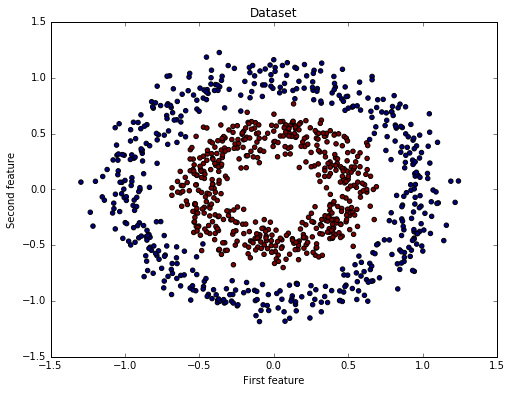

In [5]:
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)

fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.title("Dataset")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()

In [6]:
# 重塑目标获取形状(n_samples, 1)的列向量
y_true = y[:, np.newaxis]

# 把数据分割为训练集合和测试集合
X_train, X_test, y_train, y_test = train_test_split(X, y_true)

print "Shape X_train is", X_train.shape
print "Shape y_train is", y_train.shape
print "Shape X_test is", X_test.shape
print "Shape y_test is", y_test.shape

Shape X_train is (750L, 2L)
Shape y_train is (750L, 1L)
Shape X_test is (250L, 2L)
Shape y_test is (250L, 1L)


## 神经网络类

In [17]:
class NeuralNetwork:
    def __init__(self, n_inputs, n_outputs, n_hidden):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_hidden = n_hidden
        
        # 初始化权重矩阵和偏置向量
        self.W_h = np.random.randn(self.n_inputs, self.n_hidden)
        self.b_h = np.zeros((1, self.n_hidden))
        self.W_o = np.random.randn(self.n_hidden, self.n_outputs)
        self.b_o = np.zeros((1, self.n_outputs))
    def sigmoid(self, a):
        return 1.0 / (1 + np.exp(-a))
    def forward_pass(self, X):
        '''
        通过网络向前传播给定的输入
        返回值：
            A_h：所有输入样本的全部隐藏神经元的激活矩阵
            O_h：所有输入样本的全部隐藏神经元的输出矩阵
            A_o：所有输入样本的全部输出神经元的激活矩阵
            O_o：所有输入样本的全部输出神经元的输出矩阵
        '''
        # 计算隐藏单元的激活和输出
        A_h = np.dot(X, self.W_h) + self.b_h
        O_h = np.tanh(A_h)
        
        # 计算输出单元激活和输出
        A_o = np.dot(O_h, self.W_o) + self.b_o
        O_o = self.sigmoid(A_o)
        
        outputs = {
            "A_h": A_h,
            "A_o": A_o,
            "O_h": O_h,
            "O_o": O_o
        }
        
        return outputs
    def cost(self, y_true, y_predict, n_samples):
        '''计算并返回所有样本的成本'''
        # 和逻辑回归一样的损失函数
        cost = (-1.0 / n_samples) * np.sum(y_true * np.log(y_predict) + (1 - y_true) * (np.log(1 - y_predict)))
        cost = np.squeeze(cost)
        assert isinstance(cost, float)
        
        return cost
    def backward_pass(self, X, y, n_samples, outputs):
        '''
        通过网络向后传播误差
        返回值：
            dW_h：损失函数在隐含层权重方向的偏导数
            db_h：损失函数在隐含层偏置方向的偏导数
            dW_o：损失函数在输出层权重方向的偏导数
            db_o：损失函数在输出层偏置方向的偏导数
        '''
        dA_o = (outputs["O_o"] - y)
        dW_o = (1.0 / n_samples) * np.dot(outputs["O_h"].T, dA_o)
        db_o = (1.0 / n_samples) * np.sum(dA_o)
        
        dA_h = (np.dot(dA_o, self.W_o.T)) * (1 - np.power(outputs["O_h"], 2))
        dW_h = (1.0 / n_samples) * np.dot(X.T, dA_h)
        db_h = (1.0 / n_samples) * np.sum(dA_h)
        
        gradients = {
            "dW_o": dW_o,
            "db_o": db_o,
            "dW_h": dW_h,
            "db_h": db_h
        }
        
        return gradients
    def update_weights(self, gradients, eta):
        '''用固定的学习率更新模型参数'''
        self.W_o = self.W_o - eta * gradients["dW_o"]
        self.W_h = self.W_h - eta * gradients["dW_h"]
        self.b_o = self.b_o - eta * gradients["db_o"]
        self.b_h = self.b_h - eta * gradients["db_h"]
    def train(self, X, y, n_iters=500, eta=0.3):
        '''在给定的输入数据上训练神经网络'''
        n_samples, _ = X.shape
        
        for i in range(n_iters):
            outputs = self.forward_pass(X)
            cost = self.cost(y, outputs["O_o"], n_samples=n_samples)
            gradients = self.backward_pass(X, y, n_samples, outputs)
            
            if i%100 == 0:
                print "Cost at iteration {i}: {cost}".format(i=i, cost=cost)
            
            self.update_weights(gradients, eta)
    def predict(self, X):
        '''计算并返回网络对给定数据集合的预测'''
        outputs = self.forward_pass(X)
        y_pred = [1 if elem >= 0.5 else 0 for elem in outputs["O_o"]]
        
        return np.array(y_pred)[:, np.newaxis]

## 初始化并训练神经网络

In [18]:
nn = NeuralNetwork(n_inputs=2, n_hidden=6, n_outputs=1)
print "Shape of weight matrices and bias vectors:"
print "W_h:", nn.W_h.shape
print "b_h:", nn.b_h.shape
print "W_o:", nn.W_o.shape
print "b_o:", nn.b_o.shape
print "Training..."

nn.train(X_train, y_train, n_iters=2000, eta=0.7)

Shape of weight matrices and bias vectors:
W_h: (2L, 6L)
b_h: (1L, 6L)
W_o: (6L, 1L)
b_o: (1L, 1L)
Training...
Cost at iteration 0: 0.727742644457
Cost at iteration 100: 0.421883439567
Cost at iteration 200: 0.222679889311
Cost at iteration 300: 0.144189461592
Cost at iteration 400: 0.104971446918
Cost at iteration 500: 0.0839834926461
Cost at iteration 600: 0.0711084991423
Cost at iteration 700: 0.0622242347927
Cost at iteration 800: 0.0555633088463
Cost at iteration 900: 0.0502893574099
Cost at iteration 1000: 0.045963276459
Cost at iteration 1100: 0.0423309740331
Cost at iteration 1200: 0.0392310224004
Cost at iteration 1300: 0.0365516326508
Cost at iteration 1400: 0.0342107745844
Cost at iteration 1500: 0.0321475835093
Cost at iteration 1600: 0.0303178950388
Cost at iteration 1700: 0.0286898398876
Cost at iteration 1800: 0.0272389286102
Cost at iteration 1900: 0.0259442289126


## 测试神经网络

In [22]:
n_test_samples, _ = X_test.shape
y_predict = nn.predict(X_test)

print "Classification accuracy on test set: {0}%%".format((np.sum(y_predict == y_test) / float(n_test_samples)) * 100)

Classification accuracy on test set: 98.4%%


## 可视化决策边界

在图的最底下，可以看到输入空间哪些分类到正、那些分类到负——被训练过的网络。

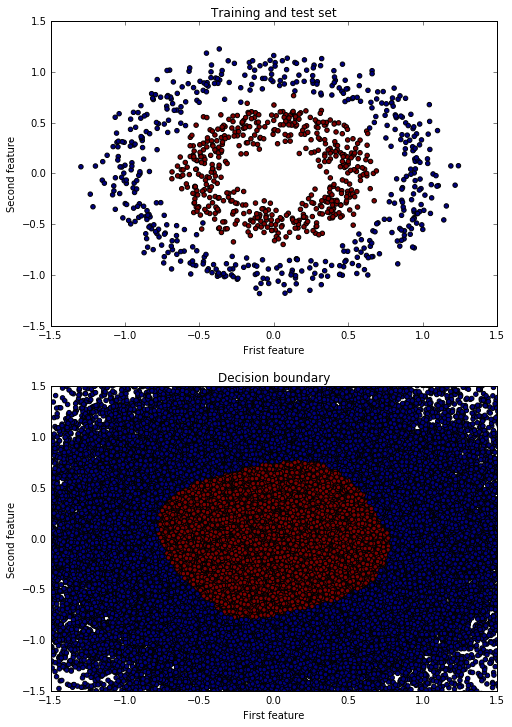

In [25]:
X_temp, y_temp = make_circles(n_samples=60000, noise=0.5)
y_predict_temp = nn.predict(X_temp)
y_predict_temp = np.ravel(y_predict_temp)

fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(2,1,1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.xlabel("Frist feature")
plt.ylabel("Second feature")
plt.title("Training and test set")

ax = fig.add_subplot(2,1,2)
plt.scatter(X_temp[:,0], X_temp[:,1], c=y_predict_temp)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.title("Decision boundary")

plt.show()